In [198]:
%matplotlib notebook
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import numpy as np #numerical python used for working with arrays, mathematical operations
import time #useful for timing functions
import sys
import glob #glob is helpful for searching for filenames or directories
import scipy #scientific python
import pickle #for saving data
from pathlib import Path
import skimage
from skimage import io
from importlib import reload
from itertools import chain, groupby
from skimage.filters import threshold_otsu, threshold_local
from skimage.transform import downscale_local_mean

### Reading in the data

To read in the data, we use the `scikit-image` (aka `skimage`) module. This module has a bunch of image processing routines and more information on it can be found [here](https://scikit-image.org/).

<IPython.core.display.Javascript object>


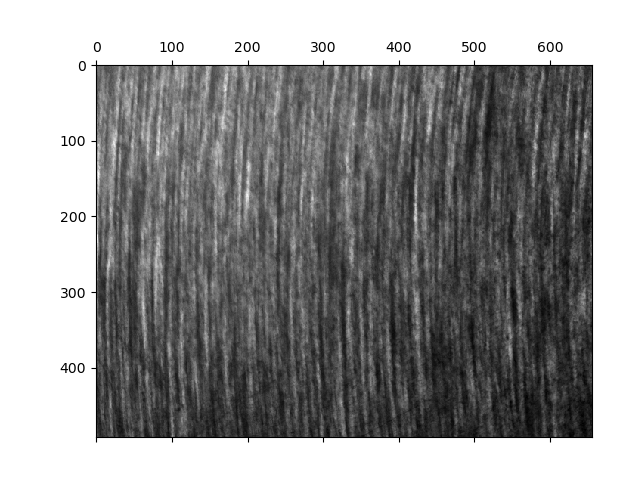

In [2]:
#Specify where the data is stored and the image data filename. Must be in tiff format
data_dir = "D:\\Dennis Terwilliger\\Data\\2021-06-08\\02_temp ramp_5Hz_(23-34Deg)_(34-23Deg)2x\\"
sub_dir = "02_temp ramp_5Hz_(23-34Deg)_(34-23Deg)2x_1\\"
data_file = "02_temp ramp_5Hz_(23-34Deg)_(34-23Deg)2x_1_MMStack_Default.ome.tif"

#Image read using tiff_file module
im = skimage.io.imread(data_dir+sub_dir+data_file)

#Display the second frame of the image
plt.matshow(im[1], cmap=matplotlib.cm.gray)

In [43]:
new_im = downscale_local_mean(im, (3,2,2))

In [44]:
print("Downscaled image dimensions: ", new_im.shape)

Downscaled image dimensions:  (667, 246, 328)


#### Finding the median image (for background subtraction)

In [45]:
im_median = np.median(new_im,axis=0)
im_median_blur = skimage.filters.gaussian(im_median, 19)

<IPython.core.display.Javascript object>


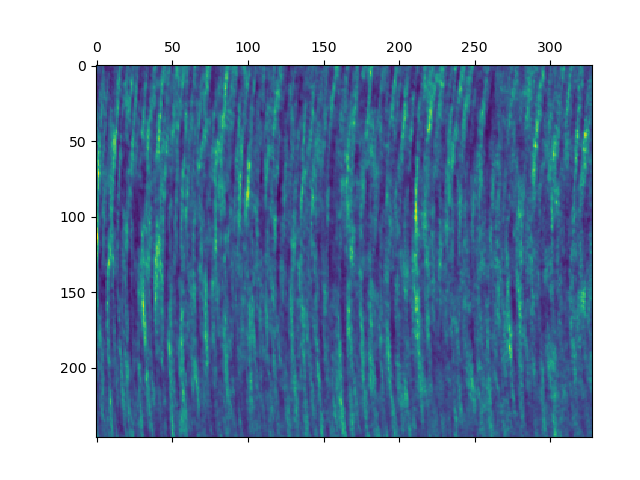

In [46]:
plt.matshow(new_im[1]-im_median_blur)

#### Generating a binary image

We'll try a couple different thersholding methods to give us a binary image. 

You can read more on these [image filtering techniques here](https://scikit-image.org/docs/dev/auto_examples/applications/plot_thresholding.html). 

Determined a threshold value of 844


<IPython.core.display.Javascript object>


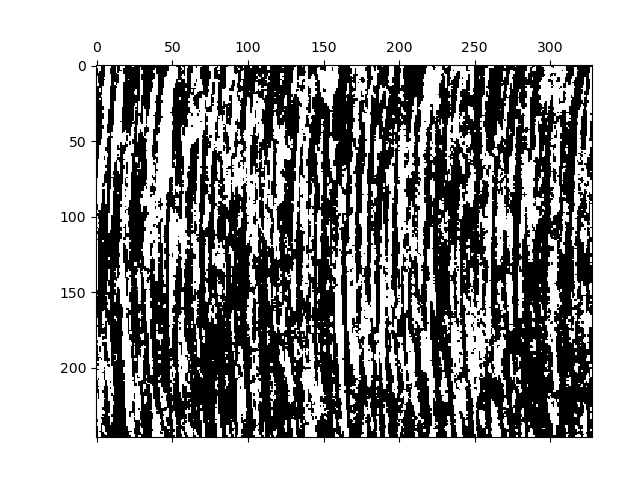

In [47]:
frame_number = 100
threshold_value = threshold_otsu(new_im[frame_number]-im_median_blur)
print("Determined a threshold value of %i" % threshold_value)
binary_image = new_im[frame_number]-im_median_blur > threshold_value

#Display the binary image
plt.matshow(binary_image, cmap=matplotlib.cm.gray)

<IPython.core.display.Javascript object>


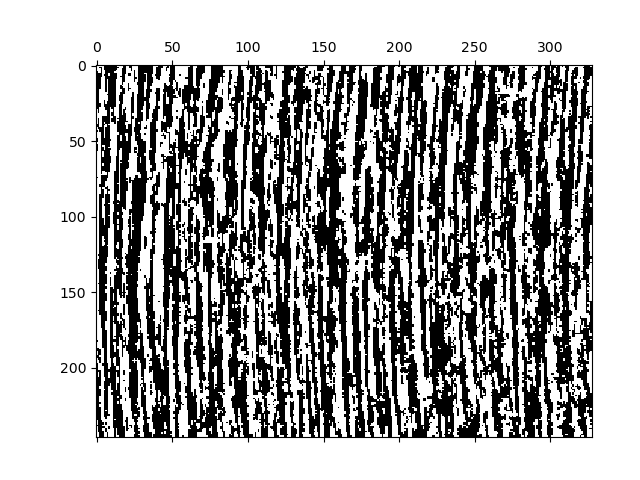

In [48]:
frame_number = 1
block_size = 51
local_thresh = threshold_local(new_im[frame_number]-im_median_blur, block_size, offset=10)
binary_image = new_im[frame_number]-im_median_blur > local_thresh

#Display the binary image
plt.matshow(binary_image, cmap=matplotlib.cm.gray)

<IPython.core.display.Javascript object>


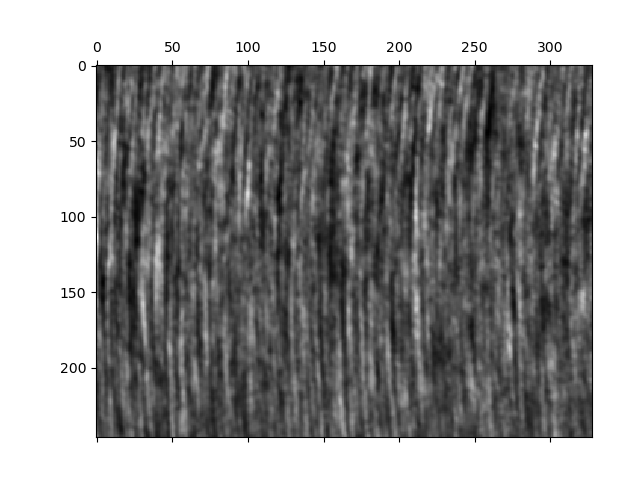

<IPython.core.display.Javascript object>


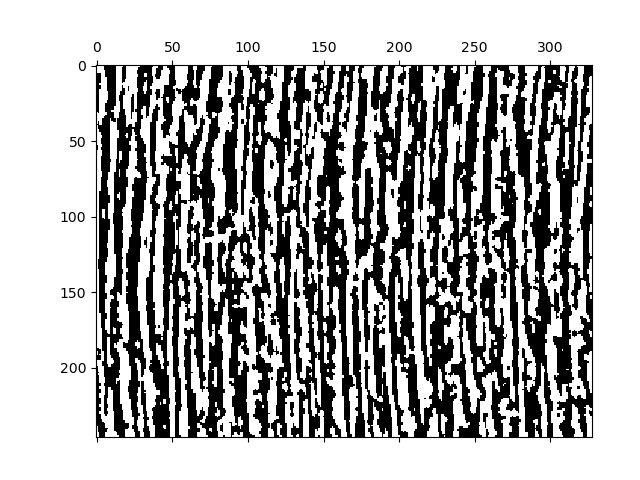

In [56]:
frame_number = 1
filtered_image = skimage.filters.gaussian(new_im[frame_number]-im_median_blur, 1)
block_size = 31
local_thresh = threshold_local(filtered_image, block_size, offset=0.01)
binary_image = filtered_image > local_thresh


plt.matshow(filtered_image, cmap=matplotlib.cm.gray)
plt.matshow(binary_image, cmap=matplotlib.cm.gray)


In [53]:
binary_image.shape

(246, 328)

In [54]:
def run_length(iterable):
    zero_runs = []
    for val, thing in groupby(iterable):
        if val==0:
            zero_runs.append(len(list(thing)))
    return zero_runs

In [173]:
def process_image(im, downscale=(3,2,2), median_blur_size=19):
    new_im = downscale_local_mean(im, downscale)
    im_median = np.median(new_im,axis=0)
    im_median_blur = skimage.filters.gaussian(im_median, median_blur_size)
    return new_im-im_median_blur

def run_length_all_images(ims, block_size=35, offset_for_threshold=10, gaussian_filter_size = None,
                         save_images_for_debugging = False, dataset_title=' ', dir_to_save=None):
    num_frames,vertical_pixels,horizontal_pixels = ims.shape
    all_runs_vertical = []
    all_runs_horizontal = []
    for i in range(num_frames):
        if gaussian_filter_size is not None:
            new_im = skimage.filters.gaussian(ims[i], gaussian_filter_size)
        else:
            new_im = ims[i]
        local_thresh = threshold_local(new_im, block_size, offset=offset_for_threshold)
        binary_image = new_im > local_thresh
        if save_images_for_debugging and i==0:
            fig, axs = plt.subplots(1, 2, figsize=(7, 4), constrained_layout=True)
            fig.suptitle(dataset_title)
            axs[0].matshow(new_im, cmap='gray')
            axs[0].set_title("image")
            axs[1].matshow(binary_image, cmap='gray')
            axs[1].set_title("binary image")
            if dir_to_save is not None:
                plt.savefig(dir_to_save + "debug_%s_image.png" % dataset_title, dpi=300)
            plt.close()
        for j in range(horizontal_pixels):
            all_runs_vertical.append(run_length(binary_image[:,j]))
        for k in range(vertical_pixels):
            all_runs_horizontal.append(run_length(binary_image[k,:]))
    return (list(chain(*all_runs_vertical)), list(chain(*all_runs_horizontal)))

In [174]:
av,ah = run_length_all_images(process_image(im)[::20], block_size=31, offset_for_threshold=0.01, gaussian_filter_size=1,
                             save_images_for_debugging=True)

In [87]:
bins = np.linspace(1,328,80)

<IPython.core.display.Javascript object>


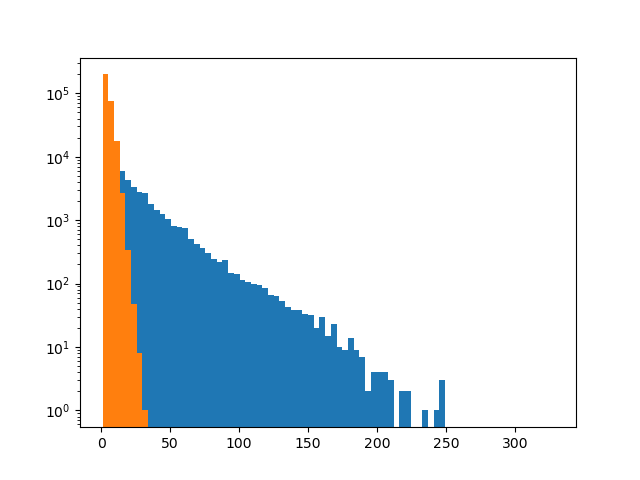

In [79]:
plt.figure()
n_vert,bins,_ = plt.hist(av, bins=bins, log=False)
n_hor,bins,_ = plt.hist(ah, bins=bins, log=True)

<IPython.core.display.Javascript object>


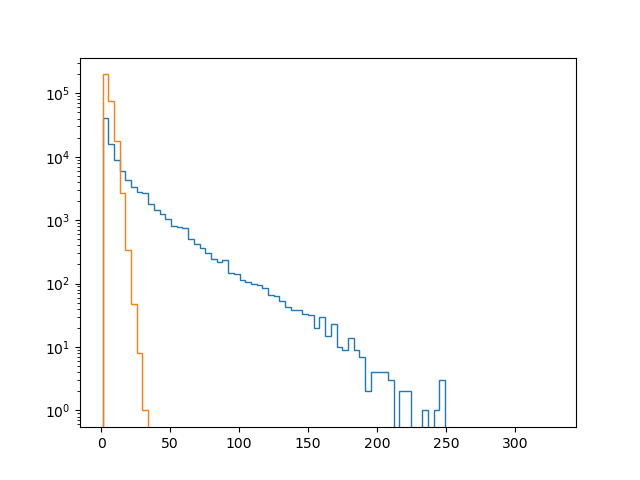

In [80]:
plt.figure()
n_vert,bins,_ = plt.hist(av, bins=bins, log=True, histtype='step')
n_hor,bins,_ = plt.hist(ah, bins=bins, log=False, histtype='step')

In [81]:
print("Mean run length in horizontal direction is %i." % np.mean(ah))
print("Mean run length in vertical direction is %i." % np.mean(av))
print("Median run length in horizontal direction is %i." % np.median(ah))
print("Median run length in vertical direction is %i." % np.median(av))

Mean run length in horizontal direction is 4.
Mean run length in vertical direction is 15.
Median run length in horizontal direction is 4.
Median run length in vertical direction is 7.


In [82]:
print("Number of runs >200 in horizontal direction is %i." % np.sum(np.array(ah)>200))
print("Number of runs >200 in vertical direction is %i." % np.sum(np.array(av)>200))

Number of runs >200 in horizontal direction is 0.
Number of runs >200 in vertical direction is 19.


In [202]:
#Specify where the data is stored 
data_dir = "D:\\Dennis Terwilliger\\Data\\2021-06-08\\02_temp ramp_5Hz_(23-34Deg)_(34-23Deg)2x\\"

movie_nums = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
list_of_subdirs = ['02_temp ramp_5Hz_(23-34Deg)_(34-23Deg)2x_%i\\' % num for num in movie_nums]
list_of_filenames = ['02_temp ramp_5Hz_(23-34Deg)_(34-23Deg)2x_%i_MMStack_Default.ome.tif' % num for num in movie_nums]

#Creating a dictionary (type of data structure in python) to save all data
all_data_dictionary = {}
all_data_dictionary['data_dir'] = data_dir

In [203]:
block_size = 71
offset_for_threshold = 0.01
gaussian_filter_size = 1
downscale_size = (3,2,2)
median_blur_size = 19
every_this_many_frames = 20
bins = np.linspace(1,328,80)

all_data_dictionary['block_size'] = block_size
all_data_dictionary['offset_for_threshold'] = offset_for_threshold
all_data_dictionary['gaussian_filter_size'] = gaussian_filter_size
all_data_dictionary['median_blur_size'] = median_blur_size
all_data_dictionary['every_this_many_frames'] = every_this_many_frames
all_data_dictionary['bins'] = bins
all_data_dictionary['list_of_subdirs'] = [] #Creating empty list to be filled in for loop below
all_data_dictionary['movie_nums'] = [] #Creating empty list to be filled in for loop below

plt.ioff()
for i,fn in enumerate(list_of_filenames):
    try:
        my_file = Path(data_dir+list_of_subdirs[i]+fn)
        if not my_file.is_file():
            print("%s does not exist." % fn)
        im = skimage.io.imread(data_dir+list_of_subdirs[i]+fn)
        all_data_dictionary['list_of_subdirs'].append(list_of_subdirs[i])
        all_data_dictionary['movie_nums'].append(movie_nums[i])
        new_im = process_image(im,downscale=downscale_size, median_blur_size=median_blur_size)
        av,ah = run_length_all_images(new_im[::every_this_many_frames], block_size=block_size, 
                                      offset_for_threshold=offset_for_threshold, gaussian_filter_size=gaussian_filter_size,
                                      save_images_for_debugging=True, dataset_title=fn, dir_to_save=data_dir+list_of_subdirs[i])
        all_data_dictionary['av_%i' % movie_nums[i]] = av
        all_data_dictionary['ah_%i' % movie_nums[i]] = ah
        n_vert,b = np.histogram(av, bins=bins)
        n_hori,b = np.histogram(ah, bins=bins)
        all_data_dictionary['nv_%i' % movie_nums[i]] = n_vert
        all_data_dictionary['nh_%i' % movie_nums[i]] = n_hori
    except:
        print("Unable to open %s" % data_dir+list_of_subdirs[i]+fn)
    

02_temp ramp_5Hz_(23-34Deg)_(34-23Deg)2x_14_MMStack_Default.ome.tif does not exist.
Unable to open D:\Dennis Terwilliger\Data\2021-06-08\02_temp ramp_5Hz_(23-34Deg)_(34-23Deg)2x\02_temp ramp_5Hz_(23-34Deg)_(34-23Deg)2x_14\02_temp ramp_5Hz_(23-34Deg)_(34-23Deg)2x_14_MMStack_Default.ome.tif


In [204]:
pickle.dump(all_data_dictionary, open(data_dir+"all_data_dict.p", "wb"))

<IPython.core.display.Javascript object>


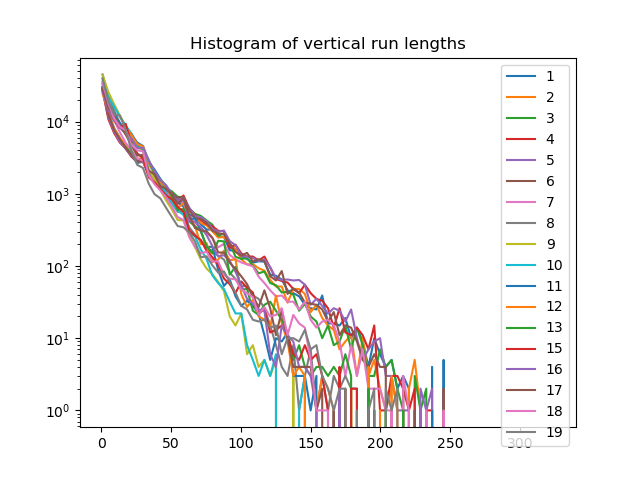

<IPython.core.display.Javascript object>


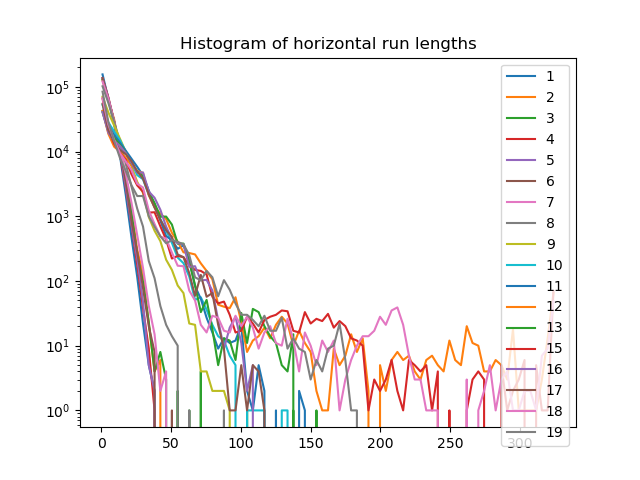

Text(0.5, 1.0, 'Histogram of horizontal run lengths')

In [206]:
plt.ion()
plt.figure()
for i,num in enumerate(all_data_dictionary['movie_nums']):
    plt.semilogy(all_data_dictionary['bins'][:-1], all_data_dictionary['nv_%i' % num], label='%i' % num)
plt.legend(loc=0)
plt.title("Histogram of vertical run lengths")

plt.figure()
for i,num in enumerate(all_data_dictionary['movie_nums']):
    plt.semilogy(all_data_dictionary['bins'][:-1], all_data_dictionary['nh_%i' % num], label='%i' % num)
plt.legend(loc=0)
plt.title("Histogram of horizontal run lengths")

<IPython.core.display.Javascript object>


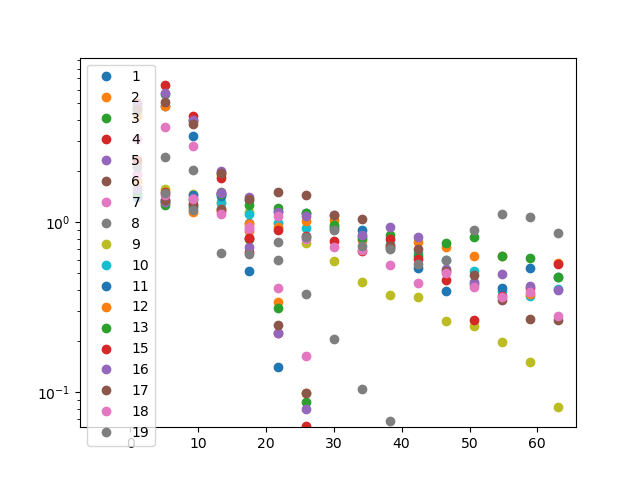

<ipython-input-207-fb2a320a5ebf>:3: RuntimeWarning: invalid value encountered in true_divide
  plt.semilogy(all_data_dictionary['bins'][:-1], all_data_dictionary['nh_%i' % num] / all_data_dictionary['nv_%i' % num], 'o', label='%i' % num)
<ipython-input-207-fb2a320a5ebf>:3: RuntimeWarning: invalid value encountered in true_divide
  plt.semilogy(all_data_dictionary['bins'][:-1], all_data_dictionary['nh_%i' % num] / all_data_dictionary['nv_%i' % num], 'o', label='%i' % num)
<ipython-input-207-fb2a320a5ebf>:3: RuntimeWarning: invalid value encountered in true_divide
  plt.semilogy(all_data_dictionary['bins'][:-1], all_data_dictionary['nh_%i' % num] / all_data_dictionary['nv_%i' % num], 'o', label='%i' % num)
<ipython-input-207-fb2a320a5ebf>:3: RuntimeWarning: invalid value encountered in true_divide
  plt.semilogy(all_data_dictionary['bins'][:-1], all_data_dictionary['nh_%i' % num] / all_data_dictionary['nv_%i' % num], 'o', label='%i' % num)
<ipython-input-207-fb2a320a5ebf>:3: RuntimeWarni

In [207]:
plt.figure()
for i,num in enumerate(all_data_dictionary['movie_nums']):
    plt.semilogy(all_data_dictionary['bins'][:-1], all_data_dictionary['nh_%i' % num] / all_data_dictionary['nv_%i' % num], 'o', label='%i' % num)
plt.legend(loc=0)


<IPython.core.display.Javascript object>


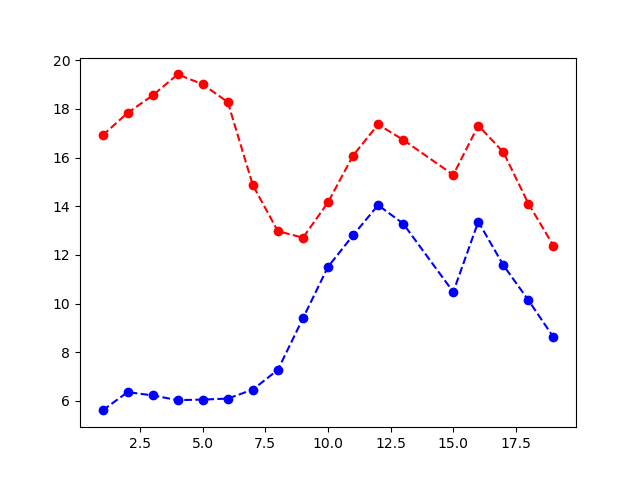

In [208]:
mean_av = [np.mean(all_data_dictionary['av_%i' % i]) for i in all_data_dictionary['movie_nums']]
mean_ah = [np.mean(all_data_dictionary['ah_%i' % i]) for i in all_data_dictionary['movie_nums']]

plt.figure()
plt.plot(all_data_dictionary['movie_nums'], mean_av, '--ro')
plt.plot(all_data_dictionary['movie_nums'], mean_ah, '--bo')

In [ ]:
data_dir = "D:\\Dennis Terwilliger\\Data\\2021-06-08\\02_temp ramp_5Hz_(23-34Deg)_(34-23Deg)2x\\"
all_data_dictionary = pickle.load(open(data_dir+"all_data_dict.p", "rb"))

In [ ]:
plt.figure()
for i,num in enumerate(all_data_dictionary['movie_nums']):
    plt.semilogy(all_data_dictionary['bins'][:-1], all_data_dictionary['nh_%i' % num] / (1+all_data_dictionary['nv_%i' % num]), 'o', label='%i' % num)
plt.legend(loc=0)

In [ ]:
plt.figure()
for i,num in enumerate(all_data_dictionary['movie_nums']):
    plt.semilogy(all_data_dictionary['bins'][:-1], (all_data_dictionary['nv_%i' % num]) / (1+all_data_dictionary['nh_%i' % num]), 'o', label='%i' % num)
plt.legend(loc=0)

<IPython.core.display.Javascript object>


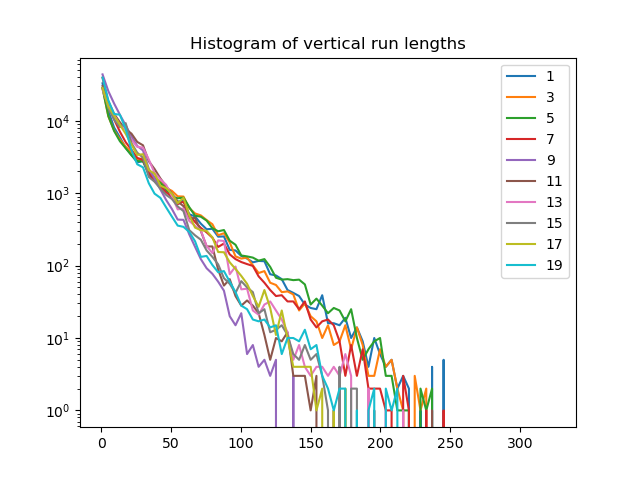

<IPython.core.display.Javascript object>


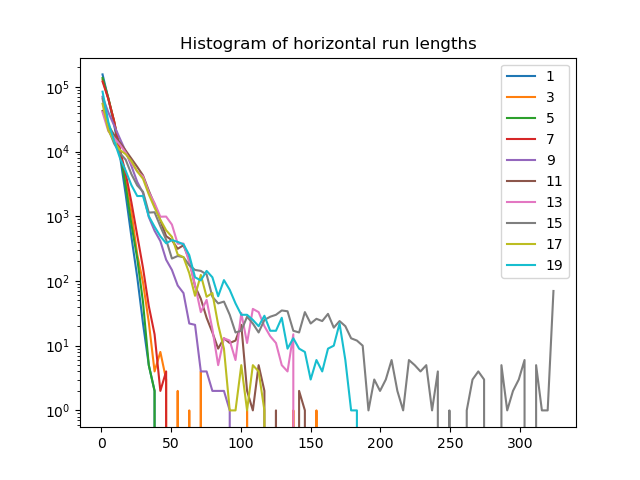

Text(0.5, 1.0, 'Histogram of horizontal run lengths')

In [193]:
plt.figure()
for i,num in enumerate(all_data_dictionary['movie_nums']):
    plt.semilogy(all_data_dictionary['bins'][:-1], all_data_dictionary['nv_%i' % num], label='%i' % num)
plt.legend(loc=0)
plt.title("Histogram of vertical run lengths")

plt.figure()
for i,num in enumerate(all_data_dictionary['movie_nums']):
    plt.semilogy(all_data_dictionary['bins'][:-1], all_data_dictionary['nh_%i' % num], label='%i' % num)
plt.legend(loc=0)
plt.title("Histogram of horizontal run lengths")

In [ ]:
mean_av = [np.mean(all_data_dictionary['av_%i' % i]) for i in all_data_dictionary['movie_nums']]
mean_ah = [np.mean(all_data_dictionary['ah_%i' % i]) for i in all_data_dictionary['movie_nums']]

plt.figure()
plt.plot(all_data_dictionary['movie_nums'], mean_av, '--ro', label='Mean vertical run length')
plt.plot(all_data_dictionary['movie_nums'], mean_ah, '--bo', label='Mean horizontal run length')
plt.legend()

In [ ]:
num_long_av = [np.sum(np.array(all_data_dictionary['av_%i' % i]) > 50) for i in all_data_dictionary['movie_nums']]
num_long_ah = [np.sum(np.array(all_data_dictionary['ah_%i' % i]) > 50) for i in all_data_dictionary['movie_nums']]

plt.figure()
plt.plot(all_data_dictionary['movie_nums'], num_long_av, '--ro', label='Number of long vertical run length')
plt.plot(all_data_dictionary['movie_nums'], num_long_ah, '--bo', label='Number of long horizontal run length')
plt.legend()

In [ ]:
data_dir = "D:\\Dennis Terwilliger\\Data\\2021-06-11\\03_Temp ramp_15Hz_(23-34Deg)_(34-23Deg)2x\\"
all_data_dictionary = pickle.load(open(data_dir+"all_data_dict.p", "rb"))

<IPython.core.display.Javascript object>


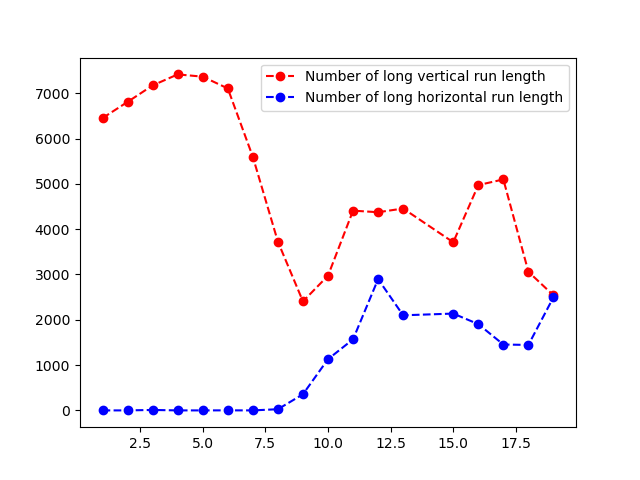

In [209]:
plt.ion()
num_long_av = [np.sum(np.array(all_data_dictionary['av_%i' % i]) > 50) for i in all_data_dictionary['movie_nums']]
num_long_ah = [np.sum(np.array(all_data_dictionary['ah_%i' % i]) > 50) for i in all_data_dictionary['movie_nums']]

plt.figure()
plt.plot(all_data_dictionary['movie_nums'], num_long_av, '--ro', label='Number of long vertical run length')
plt.plot(all_data_dictionary['movie_nums'], num_long_ah, '--bo', label='Number of long horizontal run length')
plt.legend()